# Dependencies

In [5]:
"""
DEPENDENCIES: uncomment these and run in order
""";
# !pip install --upgrade pip
# !pip install --upgrade setuptools wheel
# !pip install "git+https://github.com/facebookresearch/pytorch3d.git"
# !pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # yolov5 requirements
# !pip uninstall opencv-python--headless -y # in case open cv has problems
# !pip install opencv-python--headless==4.5.5.64 # required for yolov5
# !pip install torchshow
# !pip install plotly


# # clear tensorboard runs
# !rm -r .local/share/Trash/files/* -f

# Imports

In [1]:
import os
import torch
from render_functions import *
from ml import *
from helper import *
from tqdm import trange
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import datetime
from torchvision import transforms

os.chdir("/home/jovyan")
os.chdir("/home/jovyan/yolov5")
from models.common import DetectMultiBackend
os.chdir("/home/jovyan")

%matplotlib inline

print(f"Current path: {os.getcwd()}", end="\n\n")

specs()

Current path: /home/jovyan

Python version: 3.8.13
PyTorch3D version: 0.7.2
CUDA version: 11.7


# Initialisation

Initialise model and mesh

In [2]:
torch.cuda.empty_cache()
device = set_device()  # set device to cuda:0 if available else cpu
#device = torch.device("cpu")
print(f"Device: {device}")

now = datetime.datetime.now()
log_name = "./logs/fit/final iter test 3"

writer = SummaryWriter(log_dir=log_name)  # set writer to tensorboard

torch.cuda.is_available() is True
Cuda available
Device: cuda:0


In [4]:
# predictor model (for verification of result)
pred_model = load_model('yolov5l6', device, 0.25, 0.45, 5)

# training model (to GAN the texture)
model = DetectMultiBackend("yolov5l6.pt", device=device, dnn=False, data = 'data/coco.yaml', fp16=False)

Using cache found in /home/jovyan/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 v7.0-114-g3c0a6e6 Python-3.8.13 torch-1.13.0a0+d321be6 CUDA:0 (NVIDIA A40, 45634MiB)

Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients
Adding AutoShape... 
Fusing layers... 
YOLOv5l6 summary: 476 layers, 76726332 parameters, 0 gradients


In [5]:
# generate equally-spaced camera views
test_ELEV_BATCH = 6
test_AZIM_BATCH = 9

train_ELEV_BATCH = 9
train_AZIM_BATCH = 18

train_total_views = train_ELEV_BATCH * train_AZIM_BATCH
test_total_views = test_ELEV_BATCH * test_AZIM_BATCH
print(f"{' Train-test stats ':=^35}")
print(f"Train size: {train_total_views}")
print(f"Test size: {test_total_views}")
print(f"Train ratio: {round(train_total_views/(train_total_views + test_total_views), 3)}")

# generate cameras
test_cam = create_cameras(device, test_ELEV_BATCH, test_AZIM_BATCH, distance=5.0, elevMin=20, elevMax=70, azimMin=0, azimMax=320)
train_cam = create_cameras(device, train_ELEV_BATCH, train_AZIM_BATCH, distance=5.0, elevMin=10, elevMax=90, azimMin=0, azimMax=360)

======== Train-test stats =========
Train size: 162
Test size: 54
Train ratio: 0.75
========= Cameras created =========
54 cameras created
distance = 5.0
elev = 20 to 70 in 10.0000 degree increments
elev = 0 to 320 in 40.0000 degree increments
========= Cameras created =========
162 cameras created
distance = 5.0
elev = 10 to 90 in 10.0000 degree increments
elev = 0 to 360 in 21.1765 degree increments


In [6]:
# initialise car mesh
street = create_mesh("./meshes/street/street.obj", device, normalise=True, position=[-0.15, 0.045, -0.3], rotation=0, rot_axis="Y", size_scale=20)
car = create_mesh("./meshes/Tesla/Tesla.obj", device, normalise=True, position=[0, 0, 0], rotation=0, rot_axis="Y", size_scale=2.2)

# initialise renderer
renderer = create_render(device, bin_size=None, faces=64000, light_loc=[10, 10, 10]) 

# render car and textureUV on test camera batch
start_imgs = render_batch_paste(car, renderer, test_cam)
predicts, predicts_count = batch_predict(pred_model, start_imgs)

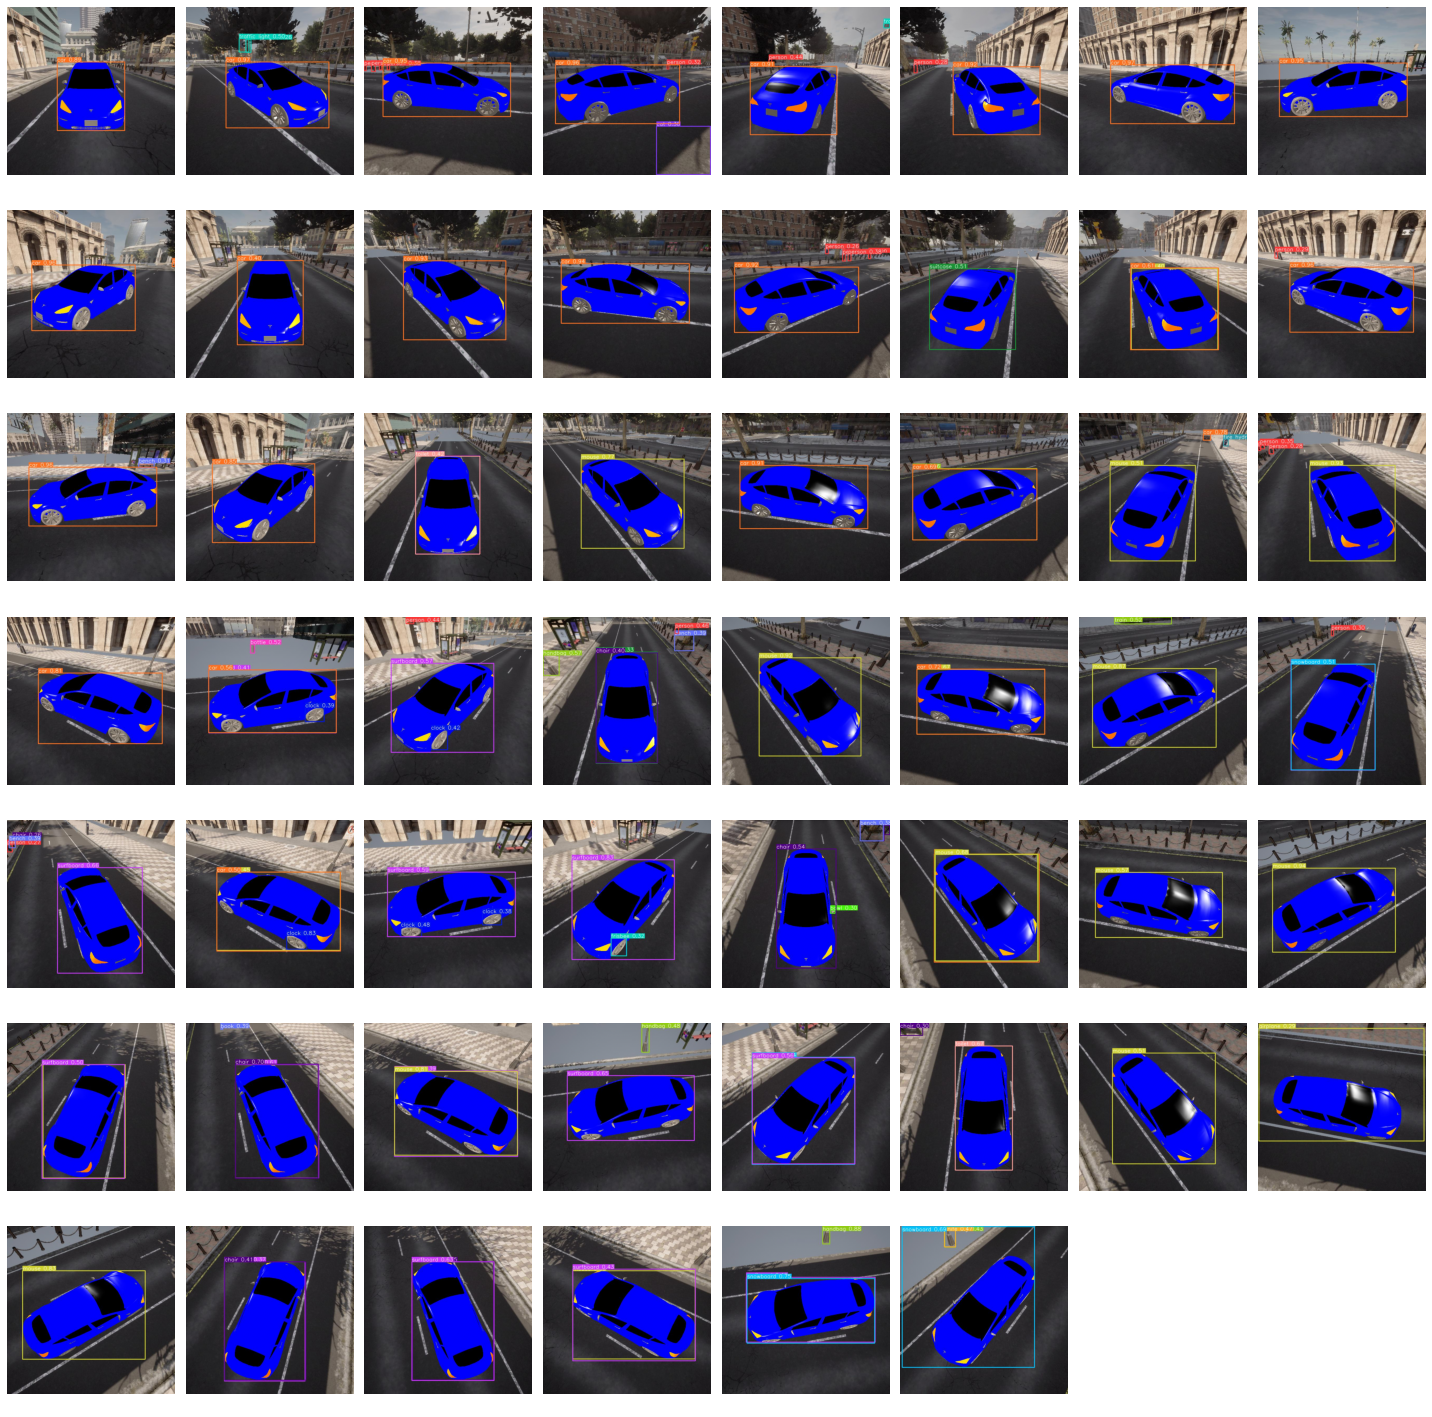

In [7]:
see(predicts, figsize=(20, 20))

In [8]:
print(predicts_count)

{'car': 23, 'suitcase': 1, 'toilet': 2, 'mouse': 10, 'surfboard': 9, 'handbag': 2, 'snowboard': 2, 'clock': 1, 'chair': 3, 'airplane': 1}


In [9]:
# copy out patch from original texture
texture_uv = get_texture_uv(car)
patch = texture_uv.detach().clone()[:, 548:, :512, :]
patch.requires_grad = True

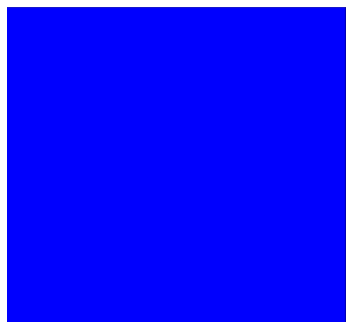

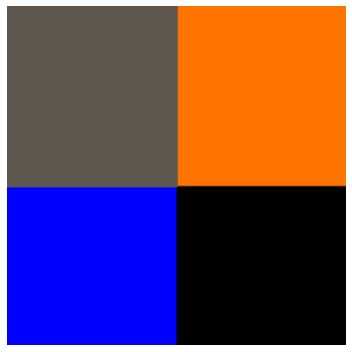

In [10]:
# verify patch
see(patch.clone().detach(), figsize=(5, 5))
see_uv(car, figsize=(5, 5))

# Training loop

In [11]:
returns = []
classes_pred = []
losses = []
preds = []
iters = []

CLASSES = [2, 3, 4, 5, 6, 7]
class_idxs = list(map(lambda x: x + 5, CLASSES))
with open("./coco_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

In [12]:
itera = 0
loss = 8
loop = trange(itera, position=0, leave=True);
MAX_VIEWS_PER_ITER = 30

Adam = torch.optim.Adam([patch], lr=0.05)
optimizer = Adam  # change this to select your preferred optimizer

torch.cuda.empty_cache()

while itera <= 100:
    torch.cuda.empty_cache()
    
    # reset optimizer and loss list
    loss = torch.tensor(0.0, device=device)
    optimizer.zero_grad()
    
    # for Low Poly Car
    copy = texture_uv.detach()
    copy[0, 548:, :512, :] = patch
    car.textures._maps_padded = copy
    
    scene = join(street, car)
    
    # render and predict on n training views
    random_views = np.random.choice(train_total_views, MAX_VIEWS_PER_ITER, replace=False)
    for view in random_views:
        render_image = renderer(scene, cameras=train_cam[int(view)].get_camera())
        image = preprocess(render_image, "pred")
        pred = model(image) # pred is 2 x 1 x 25500 x 85
        selection = torch.transpose(pred[0][0, :, 7 : 13], 0, 1) # make selection compatible with multiplication with obj [N * 6] -> [6 * N]
        obj = pred[0][:, :, 4] # [1 * N]
        loss += torch.max(selection * obj) # [N * 6] for conf for all anchor boxes. Maximum value has the index of the predicted class
    
    # avg loss over all views
    loss /= MAX_VIEWS_PER_ITER
    
    writer.add_scalar("Loss", loss, itera)
    
    if itera % 10 == 0:
        with torch.no_grad():
            current = render_one(scene, renderer, device, distance=5.0, elev=30, azim=30)
            current = current.get_image()
            current_img = current.squeeze().cpu()[..., :3].permute(2, 0, 1)
            writer.add_image("Mesh", torch.clamp(current_img, min=0.0, max=1.0), itera)
            writer.add_image("Patch", torch.clamp(patch.clone().detach().squeeze().permute(2, 0, 1), min=0.0, max=1.0), itera)
            pred_standard = predict(pred_model, current, False)
            returns.append(current_img.permute(1, 2, 0))
            if len(pred_standard.xyxy[0]) == 0:
                preds.append(None)
                writer.add_scalar("Predicted Class", -1, itera)
                classes_pred.append(-1)
            else:
                writer.add_scalar("Predicted Class", int(pred_standard.xyxy[0][0][5]), itera)
                preds.append(classes[int(pred_standard.xyxy[0][0][5])])
                classes_pred.append(int(pred_standard.xyxy[0][0][5]))
            iters.append(itera)
            
    writer.flush()

    # backprop
    loop.set_description(f"Conf loss = {loss:.6f}, iteration {itera}")
    loss.backward()
    optimizer.step()
    
    losses.append(float(loss.clone().detach()))
    itera += 1

writer.close()

Conf loss = 0.051812, iteration 14: : 0it [00:47, ?it/s]

KeyboardInterrupt: 

# Results

In [13]:
# run batch prediction to get final dicts of preds from test views
images = render_batch_paste(car, renderer, test_cam)
predicts, predict_count, adverses = batch_predict(pred_model, images, adverse=True, adverse_classes=2)
print(predict_count)

{'handbag': 5, 'car': 5, 'umbrella': 10, 'traffic light': 1, 'bed': 3, 'clock': 6, 'suitcase': 6, 'mouse': 2, 'train': 1, 'surfboard': 8, 'bench': 1, 'chair': 1, 'snowboard': 5}


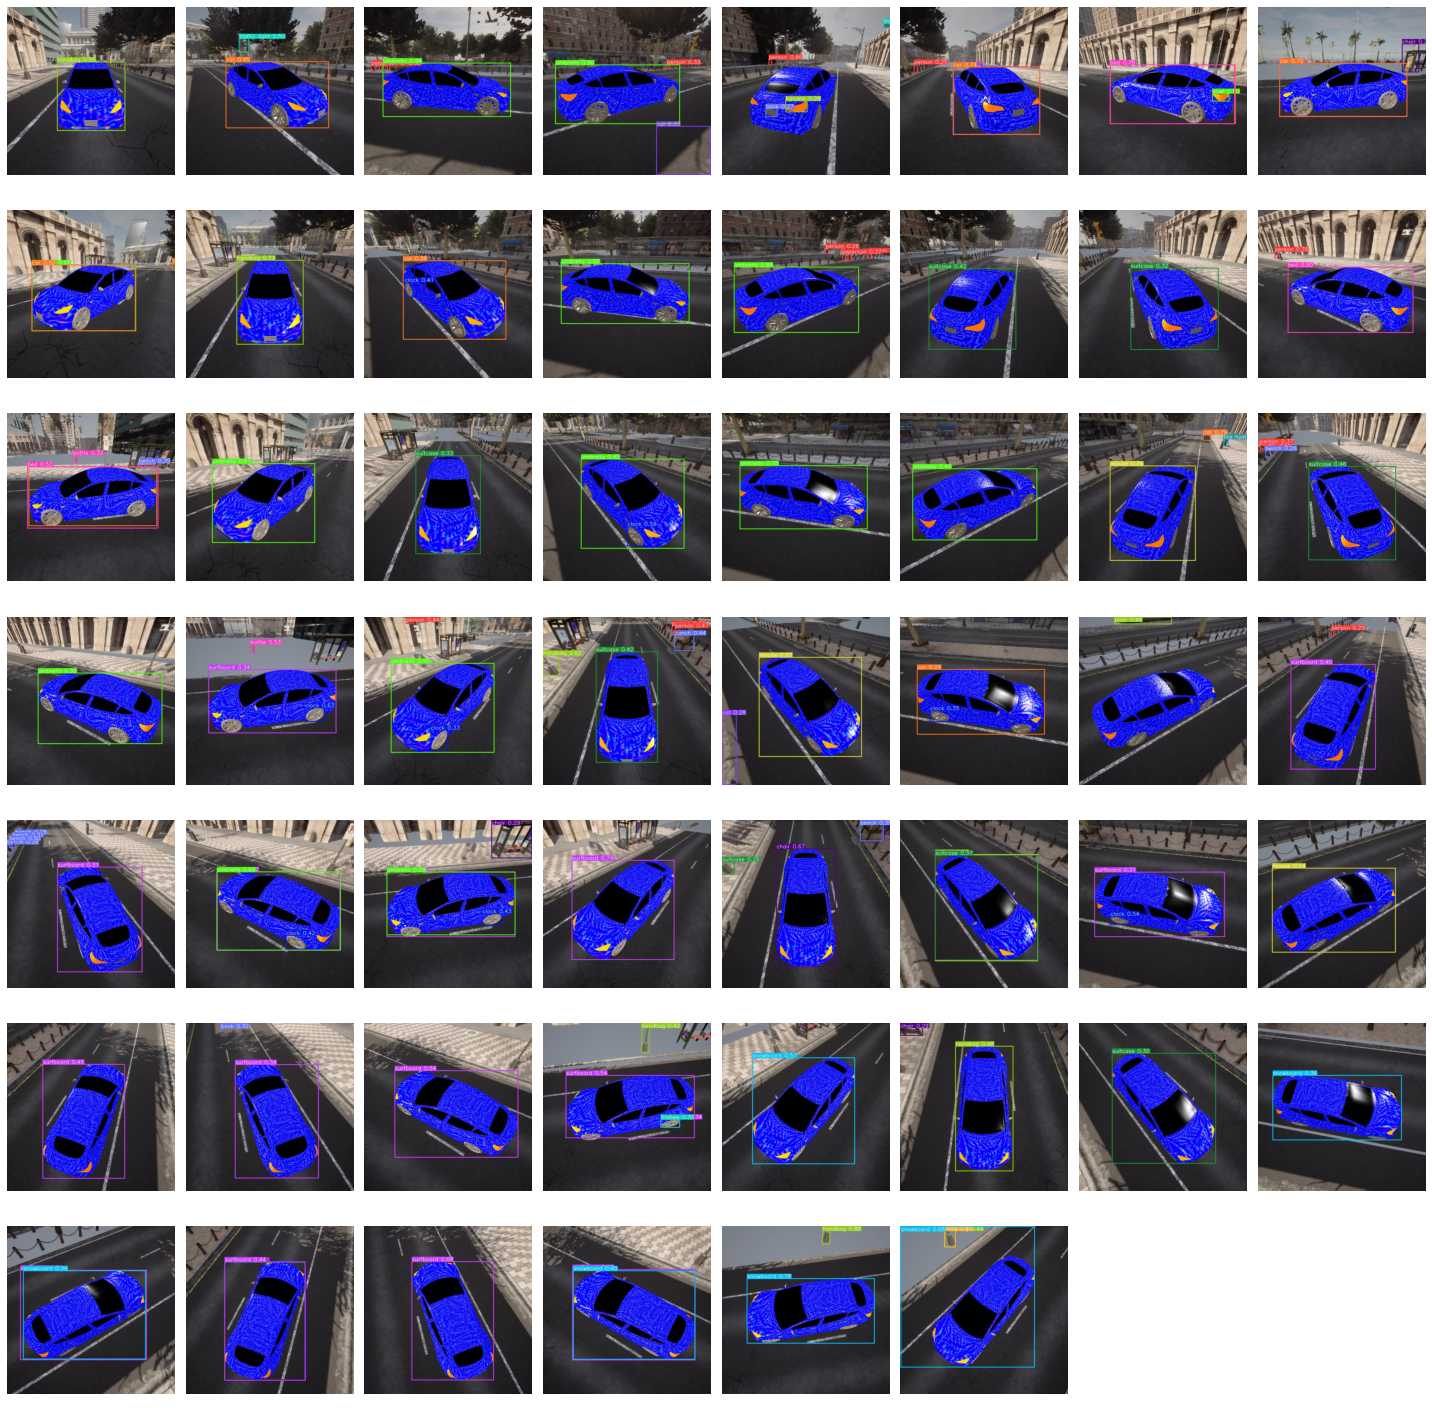

In [14]:
see(predicts, figsize=(20, 20))

In [3]:
save(predicts, path="images/final_predicts.png", figsize=(20, 20))

'path=images/final_predicts.png, figsize=(20, 20))' was not found in history, as a file, url, nor in the user namespace.


In [ ]:
adverse_views = show_adverse(adverses, figsize=(10,10))

In [ ]:
# render and predict on standard view
final = render_one(scene, renderer, device, distance=5.0, elev=30, azim=30)
_ = predict(pred_model, final, show=True)

In [ ]:
lol = render_around(scene, renderer, device, batch_size=10, distance=5.0, elevMin=45, elevMax=45, azimMin=10, azimMax=350) 

In [ ]:
see_uv(scene, figsize=(10, 10))
see(get_texture_uv(scene), path="./images/final_texture.jpg")

In [ ]:
plot_loss(losses)

In [ ]:
plot_classes(classes_pred)
print(classes_pred)